In [295]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('1clean.csv', index_col=[0])
data

,comments,sentiments,clean_comments
0,Thanks a lot for the tutorial! It helps a lot!...,1,thanks lot tutorial lot definitely way efficie...
1,this is extremely helpful mate! \r\nkeep makin...,1,extremely helpful mate keep make informative v...
2,can't we just use pytube to print the title?,0,cant use print title
3,"Hi, is it legal to scrap youtube comments ? Th...",1,hi legal scrap thanks
4,Is the code of this Video available? thanks,1,code video available thanks
5,It is sayinf that >= does not work with int an...,0,work non type help
6,it works Thanks but it is very slow. Can you d...,1,work thanks slow via
7,Can we scrape emails from these comments,0,scrape
8,Where you run this code,1,run code
9,i am so happy after watching this video. Than...,1,happy watch video much content


In [296]:

length = len(data)  # finding out length of the datframe
pos_count = len(data[data['sentiments'] == 1])  # counting positive_sentiments
neg_count = len(data[data['sentiments'] == 0])  # counting negative_sentiments
print ('length=',length,'\npos_count',pos_count,'\nneg_count',neg_count,)

length= 17 
pos_count 12 
neg_count 5


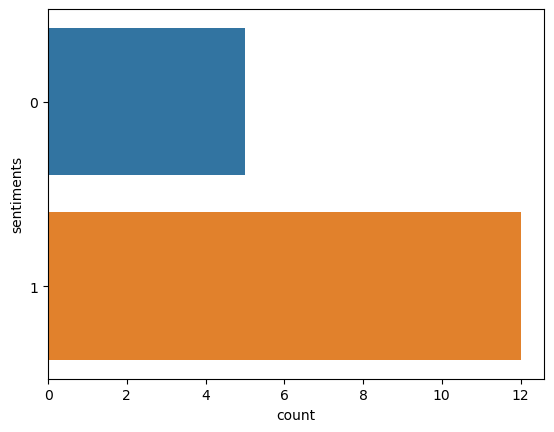

In [297]:

sns.countplot(y="sentiments",data=data)#plotting the data
plt.show()

In [298]:

def sentence_to_words(sentence):

    l = sentence.split()  # split sentence into individual word(tokanize)
    p = ''
    word_list = []

    for word in l:

        p = ''

        for letter in word:

            if ord(letter) >= 67 and ord(letter) <= 122:
                p = p + letter
        word_list.append(p)

    return word_list  # return the word list of the input comments
    

def naive_bayes_train(X, Y, a=0.000001):#a is laplace smoothing added to avoid overall prob being zero
    n_length = len(X)
    n_class_pos = len(Y[Y == 1])
    n_class_neg = len(Y[Y == 0])
    prior_pos = n_class_pos / n_length  # prior probability for  class
    prior_neg = n_class_neg / n_length  #prior probability for class 
    (n, p, bag) = bag_of_words_maker(X, Y)

    pr = {}

    for i in range(len(bag)):   #evaluating the likelihood prob for each word given a class
        p_pos = (bag['count_pos'][i] + a) / (p + len(bag) * a)

        p_neg = (bag['count_neg'][i] + a) / (n + len(bag) * a)

        pr[bag['index'][i]] = [p_pos, p_neg]
    pr = pd.DataFrame(pr).T
    pr.columns = ['sent=positive', 'sent=negative']
    pr = pr.reset_index()

    return (prior_pos, prior_neg, pr)

def naive_bayes_predict(X, pr, prior_pos, prior_neg):
    Y = []

    for i in range(len(X)):
        k_pos = 1
        k_neg = 1
        p = sentence_to_words(X[i])

        for k in range(len(pr)):

            for word in p:

                if word == pr['index'][k]:
                    k_pos = k_pos * pr['sent=positive'][k] #product of likelihood prob given the word is present in vocabulary 
                    k_neg = k_neg * pr['sent=negative'][k]

        nb = [prior_neg * k_neg, prior_pos * k_pos] # multiply each likelihood prob with the prior prob
        Y.append(np.argmax(nb))

    return Y

def bag_of_words_maker(X, Y):

    bag_dict_binary_NB_pos = {} #keeping track of the positive class words
    bag_dict_binary_NB_neg = {} #keeping track of the negative class words
  
    for i in range(len(X)):
        p = sentence_to_words(X[i])
        sent = Y[i]
        x_pos = {}
        x_neg = {} #we intialize the dict every iteration so that it does not consider repititions .(Binary NB)

        if sent == 1:
            for word in p:

                if word in x_pos.keys():
                    x_pos[word] = [x_pos[word][0] + 1, x_pos[word][1]]  #word is the key and value stored is [count, sentiment]
                else:
                    x_pos[word] = [1, sent]

            for key in x_pos.keys():

                if key in bag_dict_binary_NB_pos.keys():
                    bag_dict_binary_NB_pos[key] = \
                        [bag_dict_binary_NB_pos[key][0] + 1,
                         bag_dict_binary_NB_pos[key][1]]
                else:

                    bag_dict_binary_NB_pos[key] = [1, sent]  #storing it in the final dict 

        if sent == 0:

            for word in p:
                if word in x_neg.keys():
                    x_neg[word] = [x_neg[word][0] + 1, x_neg[word][1]]
                else:
                    x_neg[word] = [1, sent]
            for key in x_neg.keys():
                if key in bag_dict_binary_NB_neg.keys():
                    bag_dict_binary_NB_neg[key] = \
                        [bag_dict_binary_NB_neg[key][0] + 1,
                         bag_dict_binary_NB_neg[key][1]]
                else:

                    bag_dict_binary_NB_neg[key] = [1, sent]

    # print(bag_dict_multi.keys())
    # returns the dataframe containg word count in each sentiment 
    neg_bag = pd.DataFrame(bag_dict_binary_NB_neg).T
    pos_bag = pd.DataFrame(bag_dict_binary_NB_pos).T

    neg_bag.columns = ['count_neg', 'sentiment_neg']
    pos_bag.columns = ['count_pos', 'sentiment_pos']
    neg_bag = neg_bag.reset_index()
    pos_bag = pos_bag.reset_index()
    n = len(neg_bag)
    p = len(pos_bag)
    bag_of_words = pd.merge(neg_bag, pos_bag, on=['index'], how='outer')
    bag_of_words['count_neg'] = bag_of_words['count_neg'].fillna(0)
    bag_of_words['count_pos'] = bag_of_words['count_pos'].fillna(0)
    bag_of_words['sentiment_neg'] = bag_of_words['sentiment_neg'].fillna(0)
    bag_of_words['sentiment_pos'] = bag_of_words['sentiment_pos'].fillna(1)

    return (n, p, bag_of_words)



In [299]:
x = data['clean_comments']
y = data['sentiments']
(n, p, bag_of_words) = bag_of_words_maker(x, y)
print (n, ' ', p)
bag_of_words

17   81


,index,count_neg,sentiment_neg,count_pos,sentiment_pos
0,cant,1.0,0.0,1.0,1.0
1,use,1.0,0.0,0.0,1.0
2,print,1.0,0.0,0.0,1.0
3,title,1.0,0.0,0.0,1.0
4,work,1.0,0.0,2.0,1.0
...,...,...,...,...,...
88,method,0.0,0.0,1.0,1.0
89,share,0.0,0.0,1.0,1.0
90,thank,0.0,0.0,1.0,1.0
91,learn,0.0,0.0,1.0,1.0


In [300]:

(prior_pos,prior_neg,table) = naive_bayes_train(x,y)
table

,index,sent=positive,sent=negative
0,cant,1.234568e-02,5.882327e-02
1,use,1.234566e-08,5.882327e-02
2,print,1.234566e-08,5.882327e-02
3,title,1.234566e-08,5.882327e-02
4,work,2.469134e-02,5.882327e-02
...,...,...,...
88,method,1.234568e-02,5.882321e-08
89,share,1.234568e-02,5.882321e-08
90,thank,1.234568e-02,5.882321e-08
91,learn,1.234568e-02,5.882321e-08


In [301]:

from sklearn.model_selection import train_test_split

X = data["clean_comments"]
Y = data["sentiments"]
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42)#splitting comments into train 80% and test 20%

x_train = x_train.reset_index(drop=True)#dropping previous index from pandas dataframe
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

(prior_pos, prior_neg, bag) = naive_bayes_train(x_train,y_train)

y_predicted = naive_bayes_predict(x_test,bag,prior_pos,prior_neg)
y_predicted

[1, 1, 0, 1]

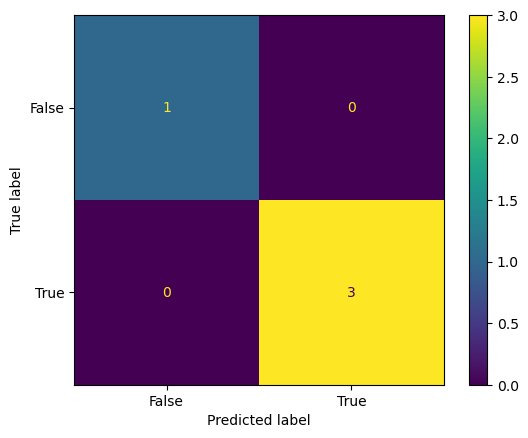

Accuracy= 1.0
precsion= 1.0
recall= 1.0
flscore 1.0


In [302]:
#getting accuracy of the model
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test,np.array(y_predicted))
(tn, fp, fn, tp) = confusion_matrix.ravel()

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

Accuracy = (tp + tn)/(tp + tn + fp + fn)
print ('Accuracy=', Accuracy)

precsion = tp / (tp + fp)
print ('precsion=', precsion)

recall = tp / (tp + fn)
print ('recall=', recall)

flscore = (2 * precsion * recall)/(precsion + recall)
print('flscore', flscore)



In [304]:
#now predecting for youtube videos individually
df = pd.read_csv('0clean.csv', index_col=[0])
Z = df['clean_comments']
print(z)
Z = Z.reset_index(drop=True)
z_predicted = naive_bayes_predict(Z, bag, prior_pos, prior_neg)
z_predicted


0                 tell drive use voice clear part video
1     ask way select channel specific country like w...
2                                        scrape instead
3     want create sentiment analysis top view excel ...
4     hello sir need scrap project similar base need...
5                              scrape data age restrict
6                         scrape please reply fast need
7                                       share code link
8                                multiple link ko scrap
9                                       cant understand
10    ho crome drive use data save ha jo se extract ...
11                                        task one shot
12                             python error aa pic help
13                       chrome driver location woo get
15                                                   hi
17                           write title speak language
18                                           thanks lot
Name: clean_comments, dtype: object


[1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1]